In [4]:
import pandas as pd

# Load dataset
df = pd.read_excel(r"C:\Users\kfq6\Documents\Data\Sammedag_master_HbA1c_Features.xlsx")

# Basic info
print("Shape:", df.shape)
print("\n--- Column Overview ---")
print(df.info())

# Check for missing values
print("\n--- Missing Values ---")
print(df.isna().sum())

# Check unique patient IDs
ID_COL = "DW_EK_Borger"  # change if your ID column is named differently
print("\n--- Patient ID Check ---")
print(f"Unique IDs: {df[ID_COL].nunique()}")
print(f"Total rows: {len(df)}")

# Optionally, show duplicates if they exist
duplicates = df[df.duplicated(subset=[ID_COL], keep=False)]
if not duplicates.empty:
    print("\n--- Duplicate IDs ---")
    print(duplicates.sort_values(by=ID_COL))
else:
    print("\nNo duplicate patient IDs found.")

# --- Keep only patients with ≥2 rows (drop single-visit patients) ---
patient_counts = df.groupby(ID_COL).size()

multi_ids = patient_counts[patient_counts >= 2].index

print(f"\nKeeping only patients with ≥2 rows...")
print(f"Patients before filter: {patient_counts.shape[0]:,}")
print(f"Patients with ≥2 rows:  {len(multi_ids):,}")
print(f"Patients dropped (only 1 row): {(patient_counts.shape[0] - len(multi_ids)):,}")

# Overwrite df with multi-row cohort
df = df[df[ID_COL].isin(multi_ids)].copy()

print(f"\nFiltered dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Unique patients after filter: {df[ID_COL].nunique():,}")


Shape: (2460, 30)

--- Column Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2460 entries, 0 to 2459
Data columns (total 30 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   DW_EK_Borger                                 2460 non-null   int64         
 1   sex                                          2460 non-null   object        
 2   age                                          2460 non-null   float64       
 3   diagnosis                                    2460 non-null   object        
 4   comp_eye                                     2460 non-null   int64         
 5   comp_renal                                   2460 non-null   int64         
 6   comp_neuro                                   2460 non-null   int64         
 7   comp_periph                                  2460 non-null   int64         
 8   comp_foot                          

In [5]:
# --- Check if certain patient IDs (e.g. hospitalized patients) exist in the master dataset ---

# hospitalized patient IDs
hospitalized_ids = [143581, 443158, 461784, 700244, 998971, 1006451, 1082134, 1114165, 1220750 ,1233676, 1237827, 1268194]

# Convert to the same dtype as in df (important for matching)
hospitalized_ids = [int(x) for x in hospitalized_ids]
df[ID_COL] = df[ID_COL].astype(int)

# Check which IDs exist
existing_ids = df[df[ID_COL].isin(hospitalized_ids)][ID_COL].unique()
missing_ids  = [i for i in hospitalized_ids if i not in existing_ids]

print(f"Total hospitalized patients checked: {len(hospitalized_ids)}")
print(f"Found in master dataset: {len(existing_ids)}")
print(f"Missing from master dataset: {len(missing_ids)}")

if len(existing_ids) > 0:
    print("\nIDs found in dataset:")
    print(existing_ids)
if len(missing_ids) > 0:
    print("\nIDs missing from dataset:")
    print(missing_ids)

# Optional: subset only hospitalized patients if you need it for further analysis
df_hosp = df[df[ID_COL].isin(hospitalized_ids)].copy()
print(f"\nSubset of hospitalized patients: {df_hosp.shape[0]} rows from {df_hosp[ID_COL].nunique()} unique patients.")


Total hospitalized patients checked: 12
Found in master dataset: 0
Missing from master dataset: 12

IDs missing from dataset:
[143581, 443158, 461784, 700244, 998971, 1006451, 1082134, 1114165, 1220750, 1233676, 1237827, 1268194]

Subset of hospitalized patients: 0 rows from 0 unique patients.


In [6]:
import pandas as pd
import numpy as np

# ---------------------------
# Constants
# ---------------------------
ID_COL = "DW_EK_Borger"
DATE_COLS = ["anchor_date", "window_start", "window_end",
             "lab_window_start", "lab_window_end", "who_date"]
DIAG_COLS = ["diagnosis_y", "diagnosis_x"]  # prefer 'y' if present
LAB_PREFIX = "LABmean__"

# Ensure datetime
for c in DATE_COLS:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

# Collect lab columns
lab_cols = [c for c in df.columns if c.startswith(LAB_PREFIX)]
# Make sure lab cols are numeric
df[lab_cols] = df[lab_cols].apply(pd.to_numeric, errors="coerce")


Distribution of sammedagsscreening per patient:

3    764
4     42
Name: count, dtype: int64

Summary stats:
count    806.000000
mean       3.052109
std        0.222385
min        3.000000
25%        3.000000
50%        3.000000
75%        3.000000
max        4.000000
dtype: float64


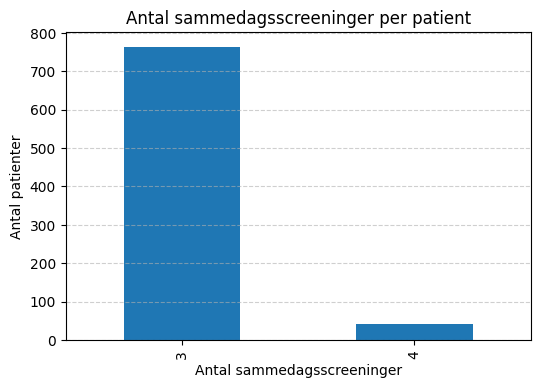

In [7]:
# --- Count sammedagsscreening per patient ---
screenings_per_patient = df.groupby(ID_COL).size()

# --- Basic stats ---
print("Distribution of sammedagsscreening per patient:\n")
print(screenings_per_patient.value_counts().sort_index())

print("\nSummary stats:")
print(screenings_per_patient.describe())

# Optional: visualize (requires matplotlib)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
screenings_per_patient.value_counts().sort_index().plot(kind='bar')
plt.title("Antal sammedagsscreeninger per patient")
plt.xlabel("Antal sammedagsscreeninger")
plt.ylabel("Antal patienter")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


In [8]:
who_cols = ["has_who_in_window", "who_score", "who_days_from_anchor"]
present = [c for c in who_cols if c in df.columns]
print("\nWHO columns present:", present)

if "has_who_in_window" in df.columns:
    print("\nWHO present value counts:\n", df["has_who_in_window"].value_counts(dropna=False))

if "who_score" in df.columns:
    print("\nWHO score describe:\n", df["who_score"].describe())



WHO columns present: ['who_score']

WHO score describe:
 count    1850.000000
mean       62.391351
std        20.293742
min         0.000000
25%        48.000000
50%        68.000000
75%        80.000000
max       100.000000
Name: who_score, dtype: float64


In [9]:
print("\n# of lab columns detected:", len(lab_cols))
print("\n% missing per lab (top 10 most missing):")
miss = df[lab_cols].isna().mean().sort_values(ascending=False)
display((100 * miss).round(1).head(10).to_frame("% missing"))

print("\nBasic lab stats (mean/SD/min/max) — transposed for readability:")
basic = df[lab_cols].describe().T
display(basic[["count", "mean", "std", "min", "25%", "50%", "75%", "max"]].round(3).head(15))



# of lab columns detected: 12

% missing per lab (top 10 most missing):


,% missing
LABmean__u_albumin_kreatinin_ratio_mg_g,17.3
LABmean__b_haemoglobin_mmol_l,16.4
LABmean__p_vitamin_b12_pmol_l,0.5
LABmean__p_kalium_mmol_l,0.1
LABmean__egfr_1_73m2_ckd_epi_ml_min,0.0
LABmean__hb_b_haemoglobin_a1c_ifcc_mmol_mol,0.0
LABmean__p_kolesterol_hdl_mmol_l,0.0
LABmean__p_kolesterol_ldl_mmol_l,0.0
LABmean__p_kolesterol_mmol_l,0.0
LABmean__p_kreatinin_umol_l,0.0



Basic lab stats (mean/SD/min/max) — transposed for readability:


,count,mean,std,min,25%,50%,75%,max
LABmean__b_haemoglobin_mmol_l,2056.0,8.690,0.923,4.700,8.10,8.700,9.350,12.217
LABmean__egfr_1_73m2_ckd_epi_ml_min,2460.0,81.594,16.168,4.000,77.75,90.000,90.000,126.000
LABmean__hb_b_haemoglobin_a1c_ifcc_mmol_mol,2460.0,61.449,12.096,31.000,53.00,60.000,68.500,142.500
LABmean__p_kalium_mmol_l,2458.0,4.046,0.336,2.800,3.80,4.000,4.265,5.600
LABmean__p_kolesterol_hdl_mmol_l,2460.0,1.455,0.419,0.600,1.20,1.400,1.700,3.600
LABmean__p_kolesterol_ldl_mmol_l,2460.0,2.284,0.741,0.200,1.80,2.200,2.700,6.300
LABmean__p_kolesterol_mmol_l,2460.0,4.280,0.880,1.850,3.70,4.200,4.800,8.200
LABmean__p_kreatinin_umol_l,2460.0,81.526,55.239,20.000,63.00,73.000,84.000,978.786
LABmean__p_natrium_mmol_l,2460.0,139.377,2.357,126.667,138.00,139.667,141.000,148.000
LABmean__p_triglycerid_mmol_l,2460.0,1.204,0.712,0.200,0.70,1.000,1.500,7.000


In [10]:
# Average lab values per diagnosis (only if not too many categories)
diag_means = (
    df.groupby("diagnosis")[lab_cols]
      .mean(numeric_only=True)
      .round(3)
      .sort_index()
)
print("\nMean lab values per diagnosis (first 10 labs):")
display(diag_means.iloc[:, :10])



Mean lab values per diagnosis (first 10 labs):


,LABmean__b_haemoglobin_mmol_l,LABmean__egfr_1_73m2_ckd_epi_ml_min,LABmean__hb_b_haemoglobin_a1c_ifcc_mmol_mol,LABmean__p_kalium_mmol_l,LABmean__p_kolesterol_hdl_mmol_l,LABmean__p_kolesterol_ldl_mmol_l,LABmean__p_kolesterol_mmol_l,LABmean__p_kreatinin_umol_l,LABmean__p_natrium_mmol_l,LABmean__p_triglycerid_mmol_l
diagnosis,,,,,,,,,,
Andre former for diabetes,8.756,76.287,59.838,4.151,1.542,2.079,4.266,88.606,139.254,1.406
Ikke specificeret diabetes,8.250,90.000,64.667,4.200,2.067,2.800,5.433,49.667,139.333,1.200
Type 1-diabetes,8.695,83.663,61.404,4.034,1.510,2.361,4.354,76.384,139.295,1.077
Type 2-diabetes,8.658,70.771,61.940,4.096,1.128,1.885,3.859,109.522,139.859,1.886


In [11]:
# %%
# ------------- CONFIG -------------
ID_COL = "DW_EK_Borger"
DATE_COL = "anchor_date"

# --- Auto-detect HbA1c and eGFR columns ---
hba1c_candidates = [c for c in df.columns if "LABmean" in c and ("LABmean__hb_b_haemoglobin_a1c_ifcc_mmol_mol" in c or "HbA1c" in c)]
egfr_candidates  = [c for c in df.columns if "LABmean" in c and "LABmean__egfr_1_73m2_ckd_epi_ml_min" in c]

if not hba1c_candidates or not egfr_candidates:
    raise ValueError("Check column names: could not auto-detect HbA1c / eGFR LABmean__ columns.")

HBA1C_COL = hba1c_candidates[0]
EGFR_COL  = egfr_candidates[0]

print(f"Using HbA1c column: {HBA1C_COL}")
print(f"Using eGFR column:  {EGFR_COL}")

# --- Ensure types ---
df[DATE_COL]    = pd.to_datetime(df[DATE_COL], errors="coerce")
df[HBA1C_COL]   = pd.to_numeric(df[HBA1C_COL], errors="coerce")
df[EGFR_COL]    = pd.to_numeric(df[EGFR_COL], errors="coerce")

# --- Sort dataset chronologically per patient ---
df_sorted = df.sort_values([ID_COL, DATE_COL])
print(f"All rows retained for analysis: {df_sorted.shape[0]:,} (covering {df_sorted[ID_COL].nunique():,} patients)")


Using HbA1c column: LABmean__hb_b_haemoglobin_a1c_ifcc_mmol_mol
Using eGFR column:  LABmean__egfr_1_73m2_ckd_epi_ml_min
All rows retained for analysis: 2,460 (covering 806 patients)



HbA1c (all measurements) summary:
count    2460.00
mean       61.45
std        12.10
min        31.00
5%         45.00
25%        53.00
50%        60.00
75%        68.50
95%        83.00
max       142.50
Name: LABmean__hb_b_haemoglobin_a1c_ifcc_mmol_mol, dtype: float64

HbA1c bands (all rows):
≤53 mmol/mol:   627 (25.5%)
>53–64 mmol/mol: 966 (39.3%)
≥75 mmol/mol:   296 (12.0%)


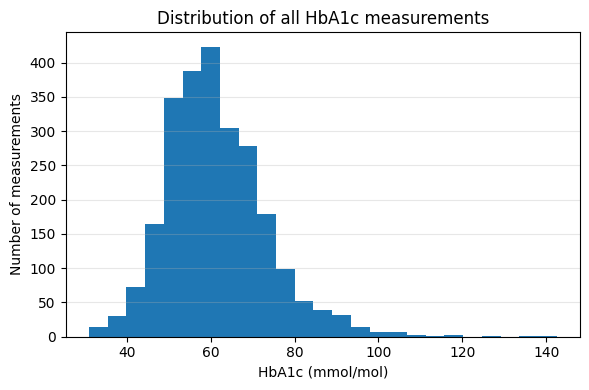

In [12]:
# %%
import matplotlib.pyplot as plt
import numpy as np

# ------------- ALL HbA1c MEASUREMENTS -------------
all_hba1c = df_sorted[HBA1C_COL].dropna()

print("\nHbA1c (all measurements) summary:")
print(all_hba1c.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).round(2))

# HbA1c bands: ≤53, 53–64, ≥75 mmol/mol
hba1c_le_53 = (all_hba1c <= 53).sum()
hba1c_53_64 = ((all_hba1c > 53) & (all_hba1c <= 64)).sum()
hba1c_ge_75 = (all_hba1c >= 75).sum()

total = len(all_hba1c)
print("\nHbA1c bands (all rows):")
print(f"≤53 mmol/mol:   {hba1c_le_53} ({hba1c_le_53/total:.1%})")
print(f">53–64 mmol/mol: {hba1c_53_64} ({hba1c_53_64/total:.1%})")
print(f"≥75 mmol/mol:   {hba1c_ge_75} ({hba1c_ge_75/total:.1%})")

plt.figure(figsize=(6,4))
plt.hist(all_hba1c, bins=25)
plt.xlabel("HbA1c (mmol/mol)")
plt.ylabel("Number of measurements")
plt.title("Distribution of all HbA1c measurements")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()





eGFR (all measurements) summary:
count    2460.00
mean       81.59
std        16.17
min         4.00
5%         44.00
25%        77.75
50%        90.00
75%        90.00
95%        90.00
max       126.00
Name: LABmean__egfr_1_73m2_ckd_epi_ml_min, dtype: float64


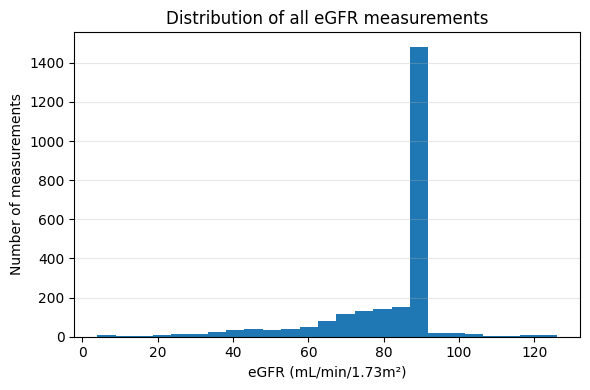


Patient-level average HbA1c & eGFR (each patient’s mean across visits):
       Mean HbA1c  Mean eGFR
count      806.00     806.00
mean        61.44      81.63
std         10.73      15.62
min         32.22       4.48
25%         54.21      77.53
50%         60.33      89.85
75%         67.96      90.00
max        123.33     118.50


In [13]:
# ------------- ALL eGFR MEASUREMENTS -------------
all_egfr = df_sorted[EGFR_COL].dropna()

print("\neGFR (all measurements) summary:")
print(all_egfr.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).round(2))

plt.figure(figsize=(6,4))
plt.hist(all_egfr, bins=25)
plt.xlabel("eGFR (mL/min/1.73m²)")
plt.ylabel("Number of measurements")
plt.title("Distribution of all eGFR measurements")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: quick look at patient-level averages
per_patient_means = (
    df_sorted.groupby(ID_COL)[[HBA1C_COL, EGFR_COL]]
    .mean(numeric_only=True)
    .rename(columns={HBA1C_COL: "Mean HbA1c", EGFR_COL: "Mean eGFR"})
)

print("\nPatient-level average HbA1c & eGFR (each patient’s mean across visits):")
print(per_patient_means.describe().round(2))


Year-to-year pairs (patients with ≥2 screenings): 1654

HbA1c year-to-year change (mmol/mol) summary:
count    1654.00
mean       -0.94
std         8.78
min       -58.00
5%        -15.50
25%        -5.00
50%        -0.50
75%         3.96
95%        12.00
max        48.00
Name: HbA1c_change, dtype: float64


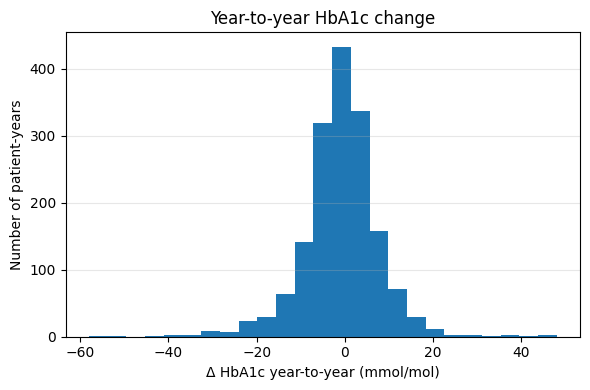


eGFR absolute year-to-year change (mL/min/1.73m²) summary:
count    1654.00
mean       -0.36
std         6.28
min       -43.61
5%        -11.00
25%        -1.00
50%         0.00
75%         0.00
95%         9.00
max        54.85
Name: eGFR_abs_change, dtype: float64

eGFR % year-to-year change summary:
count    1654.00
mean       -0.39
std        12.32
min       -50.83
5%        -14.95
25%        -1.26
50%         0.00
75%         0.00
95%        13.63
max       342.81
Name: eGFR_pct_change, dtype: float64


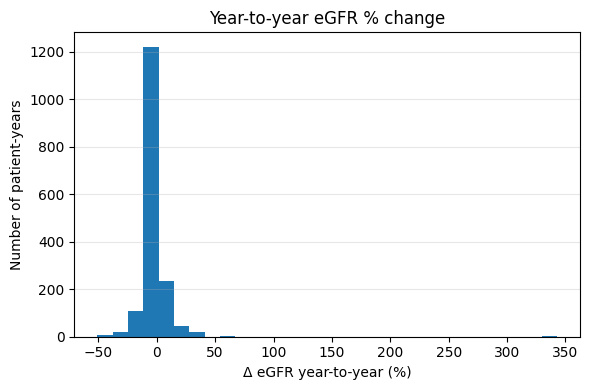

In [14]:
# ------------- YEAR-TO-YEAR CHANGES -------------
# Compute lagged values per patient
df_sorted["HbA1c_prev"] = df_sorted.groupby(ID_COL)[HBA1C_COL].shift(1)
df_sorted["eGFR_prev"]  = df_sorted.groupby(ID_COL)[EGFR_COL].shift(1)

# Only rows with a previous year available
chg = df_sorted.dropna(subset=["HbA1c_prev", "eGFR_prev"]).copy()

# HbA1c absolute change (mmol/mol)
chg["HbA1c_change"] = chg[HBA1C_COL] - chg["HbA1c_prev"]

# eGFR absolute and % change
chg["eGFR_abs_change"] = chg[EGFR_COL] - chg["eGFR_prev"]
chg["eGFR_pct_change"] = (chg["eGFR_abs_change"] / chg["eGFR_prev"]) * 100

print(f"\nYear-to-year pairs (patients with ≥2 screenings): {len(chg)}")

print("\nHbA1c year-to-year change (mmol/mol) summary:")
print(chg["HbA1c_change"].describe(percentiles=[0.05,0.25,0.5,0.75,0.95]).round(2))

plt.figure(figsize=(6,4))
plt.hist(chg["HbA1c_change"].dropna(), bins=25)
plt.xlabel("Δ HbA1c year-to-year (mmol/mol)")
plt.ylabel("Number of patient-years")
plt.title("Year-to-year HbA1c change")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print("\neGFR absolute year-to-year change (mL/min/1.73m²) summary:")
print(chg["eGFR_abs_change"].describe(percentiles=[0.05,0.25,0.5,0.75,0.95]).round(2))

print("\neGFR % year-to-year change summary:")
print(chg["eGFR_pct_change"].describe(percentiles=[0.05,0.25,0.5,0.75,0.95]).round(2))

plt.figure(figsize=(6,4))
plt.hist(chg["eGFR_pct_change"].dropna(), bins=30)
plt.xlabel("Δ eGFR year-to-year (%)")
plt.ylabel("Number of patient-years")
plt.title("Year-to-year eGFR % change")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()



In [15]:
# ------------- eGFR % CHANGE BANDS (5%-STEPS) -------------
# Bins: 5%-steps from -30% to +30%, with tails
bins = [-np.inf,
        -30, -25, -20, -15, -10, -5,
         0,
         5, 10, 15, 20, 25, 30,
         np.inf]

labels = [
    "<-30%",
    "-30 to -25%",
    "-25 to -20%",
    "-20 to -15%",
    "-15 to -10%",
    "-10 to -5%",
    "-5 to 0%",
    "0 to 5%",
    "5 to 10%",
    "10 to 15%",
    "15 to 20%",
    "20 to 25%",
    "25 to 30%",
    ">30%"
]

chg["eGFR_pct_band"] = pd.cut(chg["eGFR_pct_change"], bins=bins, labels=labels, right=True, include_lowest=True)
band_counts = chg["eGFR_pct_band"].value_counts().sort_index()

print("\neGFR % change bands (year-to-year):")
print(band_counts.to_frame("n").assign(pct=lambda x: (x["n"] / x["n"].sum() * 100).round(1)))


eGFR % change bands (year-to-year):
                  n   pct
eGFR_pct_band            
<-30%            15   0.9
-30 to -25%      10   0.6
-25 to -20%      21   1.3
-20 to -15%      37   2.2
-15 to -10%      78   4.7
-10 to -5%      130   7.9
-5 to 0%       1011  61.1
0 to 5%         147   8.9
5 to 10%         90   5.4
10 to 15%        53   3.2
15 to 20%        23   1.4
20 to 25%        11   0.7
25 to 30%         9   0.5
>30%             19   1.1


Dataset contains 2,460 rows and 806 unique patients.

=== VARIABLE COMPLETENESS OVERVIEW ===


,Variable,% Missing,Unique values,Mean,SD,Flag
0,DW_EK_Borger,0.000000,806,658887.857000,377780.276000,Good (≥80% non-missing)
26,missing_any_of_three,0.000000,1,0.000000,0.000000,Good (≥80% non-missing)
25,year,0.000000,4,2023.406000,1.082000,Good (≥80% non-missing)
22,LABmean__p_triglycerid_mmol_l,0.000000,130,1.204000,0.712000,Good (≥80% non-missing)
21,LABmean__p_natrium_mmol_l,0.000000,161,139.377000,2.357000,Good (≥80% non-missing)
20,LABmean__p_kreatinin_umol_l,0.000000,502,81.526000,55.239000,Good (≥80% non-missing)
19,LABmean__p_kolesterol_mmol_l,0.000000,177,4.280000,0.880000,Good (≥80% non-missing)
18,LABmean__p_kolesterol_ldl_mmol_l,0.000000,141,2.284000,0.741000,Good (≥80% non-missing)
17,LABmean__p_kolesterol_hdl_mmol_l,0.000000,174,1.455000,0.419000,Good (≥80% non-missing)
15,LABmean__hb_b_haemoglobin_a1c_ifcc_mmol_mol,0.000000,244,61.449000,12.096000,Good (≥80% non-missing)



=== COVERAGE BY CLINICAL GROUP ===

HbA1c: No columns found.

eGFR: No columns found.

Creatinine: No columns found.

Lipids: No columns found.

WHO-5: 1 col(s): ['who_score']
  → Patients with ≥1 value: 92.8%
  Flag: GOOD coverage

Albumin: No columns found.

Electrolytes: No columns found.

Vitamins: No columns found.

Hemoglobin: No columns found.


=== DISTRIBUTIONS FOR NUMERIC LAB VARIABLES ===


LABmean__b_haemoglobin_mmol_l — 2056 values
count    2056.00
mean        8.69
std         0.92
min         4.70
5%          7.13
25%         8.10
50%         8.70
75%         9.35
95%        10.07
max        12.22
Name: LABmean__b_haemoglobin_mmol_l, dtype: float64


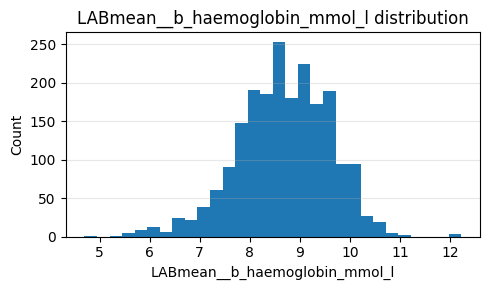


LABmean__egfr_1_73m2_ckd_epi_ml_min — 2460 values
count    2460.00
mean       81.59
std        16.17
min         4.00
5%         44.00
25%        77.75
50%        90.00
75%        90.00
95%        90.00
max       126.00
Name: LABmean__egfr_1_73m2_ckd_epi_ml_min, dtype: float64


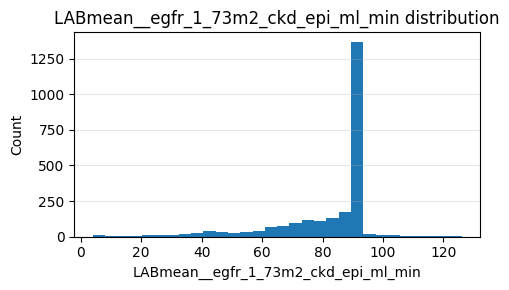


LABmean__hb_b_haemoglobin_a1c_ifcc_mmol_mol — 2460 values
count    2460.00
mean       61.45
std        12.10
min        31.00
5%         45.00
25%        53.00
50%        60.00
75%        68.50
95%        83.00
max       142.50
Name: LABmean__hb_b_haemoglobin_a1c_ifcc_mmol_mol, dtype: float64


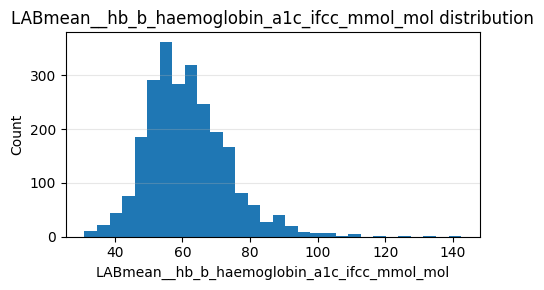


LABmean__p_kalium_mmol_l — 2458 values
count    2458.00
mean        4.05
std         0.34
min         2.80
5%          3.50
25%         3.80
50%         4.00
75%         4.26
95%         4.60
max         5.60
Name: LABmean__p_kalium_mmol_l, dtype: float64


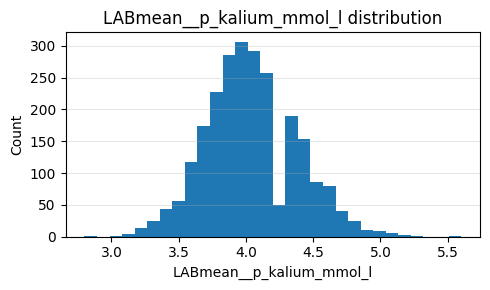


LABmean__p_kolesterol_hdl_mmol_l — 2460 values
count    2460.00
mean        1.45
std         0.42
min         0.60
5%          0.88
25%         1.20
50%         1.40
75%         1.70
95%         2.25
max         3.60
Name: LABmean__p_kolesterol_hdl_mmol_l, dtype: float64


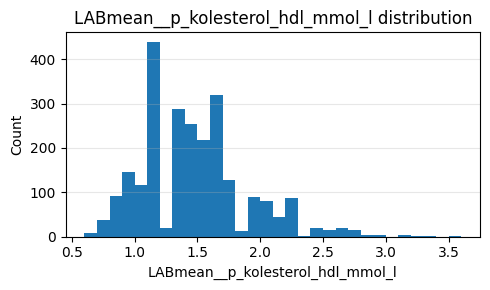


LABmean__p_kolesterol_ldl_mmol_l — 2460 values
count    2460.00
mean        2.28
std         0.74
min         0.20
5%          1.20
25%         1.80
50%         2.20
75%         2.70
95%         3.60
max         6.30
Name: LABmean__p_kolesterol_ldl_mmol_l, dtype: float64


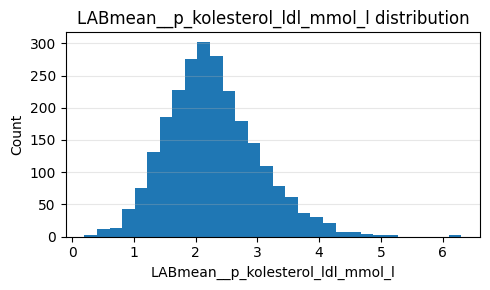


LABmean__p_kolesterol_mmol_l — 2460 values
count    2460.00
mean        4.28
std         0.88
min         1.85
5%          2.95
25%         3.70
50%         4.20
75%         4.80
95%         5.85
max         8.20
Name: LABmean__p_kolesterol_mmol_l, dtype: float64


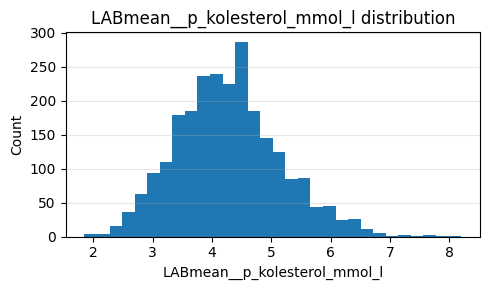


LABmean__p_kreatinin_umol_l — 2460 values
count    2460.00
mean       81.53
std        55.24
min        20.00
5%         51.00
25%        63.00
50%        73.00
75%        84.00
95%       129.00
max       978.79
Name: LABmean__p_kreatinin_umol_l, dtype: float64


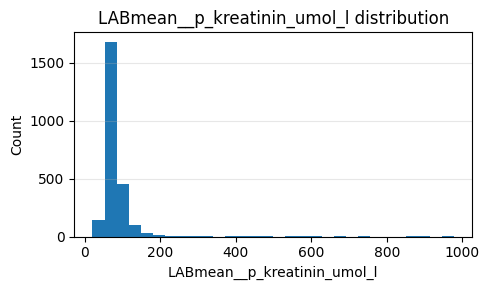


LABmean__p_natrium_mmol_l — 2460 values
count    2460.00
mean      139.38
std         2.36
min       126.67
5%        135.16
25%       138.00
50%       139.67
75%       141.00
95%       143.00
max       148.00
Name: LABmean__p_natrium_mmol_l, dtype: float64


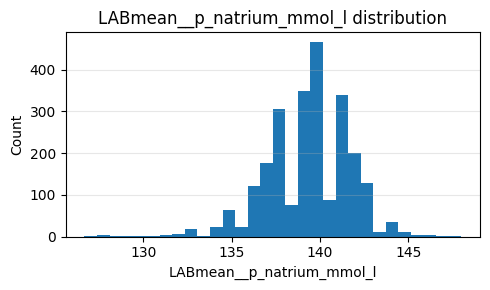


LABmean__p_triglycerid_mmol_l — 2460 values
count    2460.00
mean        1.20
std         0.71
min         0.20
5%          0.50
25%         0.70
50%         1.00
75%         1.50
95%         2.70
max         7.00
Name: LABmean__p_triglycerid_mmol_l, dtype: float64


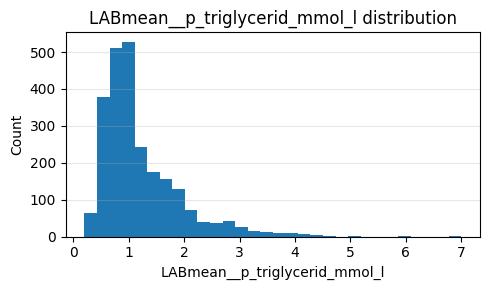


LABmean__p_vitamin_b12_pmol_l — 2447 values
count    2447.00
mean      400.16
std       182.97
min       109.00
5%        194.30
25%       280.00
50%       365.00
75%       471.00
95%       715.10
max      1476.00
Name: LABmean__p_vitamin_b12_pmol_l, dtype: float64


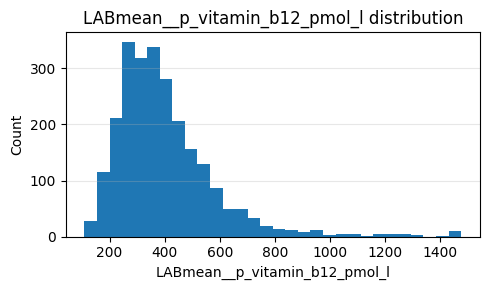


LABmean__u_albumin_kreatinin_ratio_mg_g — 2035 values
count     2035.00
mean       108.66
std        517.89
min          2.00
5%           4.00
25%          6.00
50%         11.00
75%         29.00
95%        375.30
max      11501.00
Name: LABmean__u_albumin_kreatinin_ratio_mg_g, dtype: float64


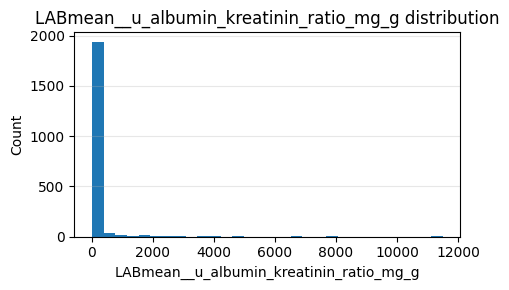


who_score — 1850 values
count    1850.00
mean       62.39
std        20.29
min         0.00
5%         24.00
25%        48.00
50%        68.00
75%        80.00
95%        88.00
max       100.00
Name: who_score, dtype: float64


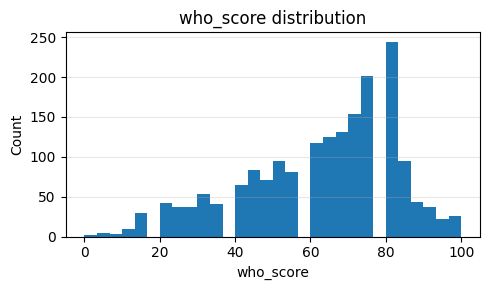

In [16]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure numeric for lab columns
lab_cols = [c for c in df.columns if c.startswith("LABmean__")]
df[lab_cols] = df[lab_cols].apply(pd.to_numeric, errors="coerce")

# ----------------------------------------
# CONFIG
# ----------------------------------------
ID_COL = "DW_EK_Borger"

# Key thematic groups (to interpret coverage)
key_groups = {
    "HbA1c": ["LABmean__Hb(B)-Hæmoglobin A1c (IFCC)_[mmol/mol]"],
    "eGFR": ["LABmean__eGFR / 1,73m²(CKD-EPI)_[ml/min]"],
    "Creatinine": ["LABmean__P-Kreatinin_[µmol/l]"],
    "Lipids": [
        "LABmean__P-Kolesterol_[mmol/l]",
        "LABmean__P-Kolesterol LDL_[mmol/l]",
        "LABmean__P-Kolesterol HDL_[mmol/l]",
        "LABmean__P-Triglycerid_[mmol/l]"
    ],
    "WHO-5": ["who_score"],
    "Albumin": [
        "LABmean__P-Albumin_[g/l]",
        "LABmean__U-Albumin / Kreatinin-ratio_[mg/g]"
    ],
    "Electrolytes": [
        "LABmean__P-Kalium_[mmol/l]",
        "LABmean__P-Natrium_[mmol/l]",
        "LABmean__P-Calcium (albuminkorrigeret)_[mmol/l]",
        "LABmean__P-Calcium_[mmol/l]"
    ],
    "Vitamins": [
        "LABmean__P-25-Hydroxy-Vitamin D(D3+D2)_[nmol/l]",
        "LABmean__P-Vitamin B12_[pmol/l]"
    ],
    "Hemoglobin": ["LABmean__B-Hæmoglobin_[mmol/l]"]
}

# ----------------------------------------
# DESCRIPTIVE SUMMARY
# ----------------------------------------
summary = []
n_rows = len(df)
n_patients = df[ID_COL].nunique()

print(f"Dataset contains {n_rows:,} rows and {n_patients:,} unique patients.\n")

for col in df.columns:
    miss_pct = df[col].isna().mean() * 100
    nunique = df[col].nunique(dropna=True)

    if pd.api.types.is_numeric_dtype(df[col]):
        mean = df[col].mean()
        std = df[col].std()
        flag = (
            "Good (≥80% non-missing)"
            if miss_pct <= 20 else
            "Moderate (20–50% missing)"
            if miss_pct <= 50 else
            "Weak (>50% missing)"
        )
    else:
        mean = np.nan
        std = np.nan
        flag = "Non-numeric or categorical"

    summary.append({
        "Variable": col,
        "% Missing": round(miss_pct, 1),
        "Unique values": nunique,
        "Mean": round(mean, 3) if not np.isnan(mean) else None,
        "SD": round(std, 3) if not np.isnan(std) else None,
        "Flag": flag
    })

summary_df = pd.DataFrame(summary)
summary_df = summary_df.sort_values("% Missing", ascending=True)

print("=== VARIABLE COMPLETENESS OVERVIEW ===")
display(summary_df.style.background_gradient(subset=["% Missing"], cmap="Reds"))

# ----------------------------------------
# PER-GROUP COVERAGE
# ----------------------------------------
print("\n=== COVERAGE BY CLINICAL GROUP ===\n")

for group, cols in key_groups.items():
    existing = [c for c in cols if c in df.columns]
    if not existing:
        print(f"{group}: No columns found.\n")
        continue
    any_val = df[existing].notna().any(axis=1)
    patient_cov = 100 * df.loc[any_val, ID_COL].nunique() / n_patients
    print(f"{group}: {len(existing)} col(s): {existing}")
    print(f"  → Patients with ≥1 value: {patient_cov:.1f}%")
    if patient_cov >= 80:
        print("  Flag: GOOD coverage\n")
    elif patient_cov >= 50:
        print("  Flag: MODERATE coverage (imputation acceptable)\n")
    else:
        print("  Flag: WEAK coverage (consider dropping)\n")

# ----------------------------------------
# DISTRIBUTIONS FOR NUMERIC VARIABLES
# ----------------------------------------
print("\n=== DISTRIBUTIONS FOR NUMERIC LAB VARIABLES ===\n")

for col in lab_cols + ["who_score"]:
    if col not in df.columns:
        continue
    s = pd.to_numeric(df[col], errors="coerce").dropna()
    if len(s) < 10:
        continue

    print(f"\n{col} — {len(s)} values")
    print(s.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).round(2))

    plt.figure(figsize=(5,3))
    plt.hist(s, bins=30)
    plt.title(f"{col} distribution")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()



=== PATIENT GROUP SUMMARY ===
Total unique patients: 806
Patients with only one row: 0 (0.0%)
Patients with ≥2 rows: 806 (100.0%)

Distribution of number of rows per patient:
3    764
4     42
Name: count, dtype: int64


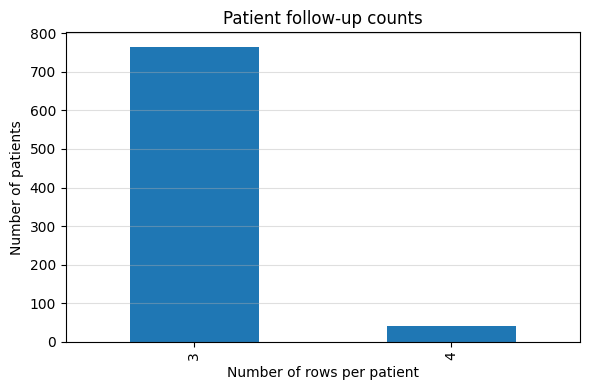


Multi-row dataset: 2,460 rows from 806 patients.
Single-row dataset: 0 rows from 0 patients.


In [17]:
# %%
import pandas as pd

ID_COL = "DW_EK_Borger"

# --- group counts ---
patient_counts = df.groupby(ID_COL).size()

n_total = patient_counts.shape[0]
n_single = (patient_counts == 1).sum()
n_multi = (patient_counts >= 2).sum()

print("=== PATIENT GROUP SUMMARY ===")
print(f"Total unique patients: {n_total:,}")
print(f"Patients with only one row: {n_single:,} ({n_single/n_total:.1%})")
print(f"Patients with ≥2 rows: {n_multi:,} ({n_multi/n_total:.1%})")

print("\nDistribution of number of rows per patient:")
print(patient_counts.value_counts().sort_index())

# --- visualize distribution ---
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
patient_counts.value_counts().sort_index().plot(kind="bar")
plt.xlabel("Number of rows per patient")
plt.ylabel("Number of patients")
plt.title("Patient follow-up counts")
plt.grid(axis="y", alpha=0.4)
plt.tight_layout()
plt.show()

# --- subset creation ---
df_multi = df[df[ID_COL].isin(patient_counts[patient_counts >= 2].index)].copy()
df_single = df[df[ID_COL].isin(patient_counts[patient_counts == 1].index)].copy()

print(f"\nMulti-row dataset: {df_multi.shape[0]:,} rows from {n_multi:,} patients.")
print(f"Single-row dataset: {df_single.shape[0]:,} rows from {n_single:,} patients.")


In [18]:
import pandas as pd

# --- Inputs ---
ID_COL = "DW_EK_Borger"
WHO_COL = "who_score"

# Load data
df = pd.read_excel(r"C:\Users\kfq6\Documents\Data\Sammedag_master_means_3m_3to4.xlsx")


# --- Keep only patients with ≥2 rows (drop single-visit patients) ---
patient_counts = df.groupby(ID_COL).size()

multi_ids = patient_counts[patient_counts >= 2].index

print(f"\nKeeping only patients with ≥2 rows...")
print(f"Patients before filter: {patient_counts.shape[0]:,}")
print(f"Patients with ≥2 rows:  {len(multi_ids):,}")
print(f"Patients dropped (only 1 row): {(patient_counts.shape[0] - len(multi_ids)):,}")

# Overwrite df with multi-row cohort
df = df[df[ID_COL].isin(multi_ids)].copy()

print(f"\nFiltered dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Unique patients after filter: {df[ID_COL].nunique():,}")



# 1) Row-level flag: is WHO-5 missing on this row?
df["who_missing_row"] = df[WHO_COL].isna()

# 2) Patient-level: does the patient EVER have a WHO-5?
patient_has_any_who = (
    df.groupby(ID_COL)[WHO_COL]
      .apply(lambda x: x.notna().any())
      .rename("patient_has_any_who")
)

df = df.merge(patient_has_any_who, on=ID_COL)

# 3) Patient-level: is the patient NEVER having WHO-5 on ANY row?
df["patient_never_has_WHO"] = ~df["patient_has_any_who"]

# 4) Rows where WHO-5 is missing BUT patient has WHO-5 elsewhere
df["who_missing_in_partial_patient"] = (
    df["who_missing_row"] & df["patient_has_any_who"]
)



# --- Summaries ---

total_patients = df[ID_COL].nunique()
patients_never_who = (
    df.loc[df["patient_never_has_WHO"], ID_COL]
      .drop_duplicates()
)
patients_partial_who = (
    df.loc[df["who_missing_in_partial_patient"], ID_COL]
      .drop_duplicates()
)

print(f"Total patients: {total_patients}")
print(f"Patients with NO WHO-5 at all: {len(patients_never_who)}")
print(f"Patients with PARTIAL WHO-5 (some rows missing, some present): {len(patients_partial_who)}")

print("\nExample rows with missing WHO-5 in patients who have it elsewhere:")
print(
    df.loc[df["who_missing_in_partial_patient"],
           [ID_COL, "anchor_date", WHO_COL, "who_missing_row", "patient_has_any_who"]]
      .sort_values([ID_COL, "anchor_date"])
      .head(20)
)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\kfq6\\Documents\\Data\\Sammedag_master_means_3m_3to4.xlsx'

In [ ]:
import pandas as pd

# === Inputs ===
LAB_PATH = r"C:\Users\kfq6\Documents\Data\LABKA.xlsx"  # <-- ret til korrekt filnavn
ID_COL = "DW_EK_Borger"

# Tjek at multi_ids findes fra din tidligere celle
try:
    multi_ids
except NameError:
    raise RuntimeError(
        "multi_ids er ikke defineret. Kør cellen med Sammedag_master_means-filtreringen først."
    )

# === 1. Indlæs originalt LAB-datasæt ===
labs = pd.read_excel(LAB_PATH)

# Sikr at dato-kolonnen er i datetime-format
labs["Dato_Proevetagningstid"] = pd.to_datetime(
    labs["Dato_Proevetagningstid"], errors="coerce"
)

# Smid rækker uden gyldig prøvedato
labs = labs[~labs["Dato_Proevetagningstid"].isna()].copy()

# Tilføj år
labs["year"] = labs["Dato_Proevetagningstid"].dt.year

# Begræns til 2022 og frem
labs = labs[labs["year"] >= 2022].copy()

# === 2. Begræns til inkluderede patienter (kun dem med ≥2 sammedagsscreeninger) ===
labs = labs[labs[ID_COL].isin(multi_ids)].copy()

print(f"Antal inkluderede patienter i LAB-datasættet: {labs[ID_COL].nunique()}")
print(f"Antal LAB-rækker (tests) fra 2022+: {len(labs):,}")

# === 3. Beregn antal prøver per patient per år ===
per_patient_year = (
    labs
    .groupby([ID_COL, "year"])
    .agg(
        n_tests_total=("Analysenavn", "size"),              # alle rækker = alle prøvesvar
        n_unique_analyses=("Analysenavn", "nunique"),       # forskellige analysetyper
        n_unique_test_dates=("Dato_Proevetagningstid", "nunique")  # hvor mange datoer
    )
    .reset_index()
)

print("\nEksempel på patient-år niveau (top 10 rækker):")
print(per_patient_year.head(10))

# === 4. Årsoversigt for hele kohorten ===
year_summary = (
    per_patient_year
    .groupby("year")
    .agg(
        n_patients=("DW_EK_Borger", "nunique"),
        mean_tests_per_patient=("n_tests_total", "mean"),
        median_tests_per_patient=("n_tests_total", "median"),
        mean_unique_analyses=("n_unique_analyses", "mean"),
        median_unique_analyses=("n_unique_analyses", "median"),
    )
    .reset_index()
)

print("\nÅrsoversigt for inkluderede patienter (2022+):")
print(year_summary.to_string(index=False))


c:\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Antal inkluderede patienter i LAB-datasættet: 907
Antal LAB-rækker (tests) fra 2022+: 104,646

Eksempel på patient-år niveau (top 10 rækker):
   DW_EK_Borger  year  n_tests_total  n_unique_analyses  n_unique_test_dates
0          7371  2022             22                 16                    2
1          7371  2023              2                  2                    1
2          7371  2024             12                 12                    1
3          7371  2025             12                 12                    1
4          8395  2022             13                 11                    3
5          8395  2023             12                 12                    1
6          8395  2024             12                 12                    1
7          8395  2025              7                  7                    1
8         10562  2022             11                 11                    1
9         10562  2023             34                 16                    3

Årsoversig